# Housing Price Predictor

## Configuration

In [56]:
# Librairies

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import numpy as np
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import joblib

from utilities import analyse

## Global

In [57]:
# Constants

from constants import *

## Data

### Data Retrieval

In [63]:
# Data Retrieval

columns = DATA_CLEAN_COLUMNS
data = pd.read_csv(DATA_CLEAN_FILE_PATH, usecols=columns, low_memory=False)
data = data.head(150_000)

In [64]:
# Data Preparation

y = data[DATA_VALEUR_FONCIERE_COLUMN].astype(float)
x = data.copy().drop([DATA_VALEUR_FONCIERE_COLUMN], axis=1)

In [65]:
# Analysis

analyse(data)

,NA,Uniques,types
date_mutation,0,319,object
valeur_fonciere,0,10778,float64
code_postal,0,704,float64
type_local,0,2,object
surface_reelle_bati,0,430,float64
nombre_pieces_principales,0,21,float64
surface_terrain,0,4105,float64
longitude,0,51598,float64
latitude,0,51480,float64


### Data Preparation

#### Transformers

In [66]:
from transfomers import *

#### Transformation

In [67]:
# Data Transformation Pipeline

categorical_features = [DATA_TYPE_LOCAL_COLUMN]
numerical_features = [
	DATA_SURFACE_REELLE_COLUMN, DATA_SURFACE_TERRAIN_COLUMN, DATA_NB_PIECES_COLUMN,
	DATA_TIME_COLUMN
]

column_transformer = ColumnTransformer(
	transformers=[
		("num", StandardScaler(), numerical_features),
		("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
	],
	remainder="passthrough"
)

transformation_pipeline = Pipeline([
	("type", TypeTransformer()),
	("feat", FeaturesExtractor()),
	("cols", column_transformer)
])

transformation_pipeline

,steps,"[('type', ...), ('feat', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,str_features,"['code_postal', 'type_local']"
,num_features,"['surface_reelle_bati', 'surface_terrain', ...]"
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None


## Model Training

In [50]:
# Functions

def train_test(model, x, y):
	data_split = train_test_split(x, y)
	x_train, x_test, y_train, y_test = data_split

	# Training
	model.fit(x_train, y_train)

	# Validation
	train_pred = model.predict(x_train)

	train_results = (
		round(np.sqrt(mean_squared_error(y_train, train_pred)), 2),
		round(r2_score(y_train, train_pred), 2),
		round(mean_absolute_error(y_train, train_pred), 2)
	)

	# Test
	test_pred = model.predict(x_test)

	test_results = (
		round(np.sqrt(mean_squared_error(y_test, test_pred)), 2),
		round(r2_score(y_test, test_pred), 2),
		round(mean_absolute_error(y_test, test_pred), 2)
	)

	return model, data_split, train_pred, test_pred, train_results, test_results

def plot_results(y_train, train_pred, y_test, test_pred):
	fig, axs = plt.subplots(1, 2)
	axs[0].scatter(y_train, train_pred, s=10, color="black")
	axs[0].plot(
		[min(y_train.min(), train_pred.min()), max(y_train.max(), train_pred.max())],
		[min(y_train.min(), train_pred.min()), max(y_train.max(), train_pred.max())],
		color="red"
	)
	axs[0].set_title("Train")

	axs[1].scatter(y_test, test_pred, s=10, color="black")
	axs[1].plot(
		[min(y_test.min(), test_pred.min()), max(y_test.max(), test_pred.max())],
		[min(y_test.min(), test_pred.min()), max(y_test.max(), test_pred.max())],
		color="red"
	)
	axs[1].set_title("Test")

	fig.set_figwidth(15)
	fig.set_figheight(5)

### XGBoost

#### Test

In [ ]:
model = TransformedTargetRegressor(
	regressor=XGBRegressor(n_jobs=12),
	transformer=PowerTransformer("yeo-johnson")
)

data_split = train_test_split(x, y)
x_train, x_test, y_train, y_test = data_split

x = TypeTransformer().fit_transform(x)

x

In [ ]:
x = FeaturesExtractor().fit_transform(x, y)

x

In [ ]:
analyse(x)

#### Real

In [ ]:
model = TransformedTargetRegressor(
	regressor=XGBRegressor(n_jobs=12),
	transformer=PowerTransformer("yeo-johnson")
)

main_pipeline = Pipeline([
	("trans", transformation_pipeline),
	("train", model)
])

In [ ]:
# Training & Test

model = TransformedTargetRegressor(
	regressor=XGBRegressor(n_jobs=12),
	transformer=PowerTransformer("yeo-johnson")
)

main_pipeline = Pipeline([
	("trans", transformation_pipeline),
	("train", model)
])

xgb_trained_model, data_split, train_pred, test_pred, train_results, test_results = train_test(main_pipeline, x, y)
_, x_test, y_train, y_test = data_split

In [ ]:
# Model

model

In [ ]:
# Results

print(f"Train - RAE : {train_results[2]} - RMSE : {train_results[0]} - R2 : {train_results[1]}")
print(f"Test - RAE : {test_results[2]} - RMSE : {test_results[0]} - R2 : {test_results[1]}")

In [ ]:
# Visualization

plot_results(y_train, train_pred, y_test, test_pred)

In [ ]:
# Save

test = x_test.copy()
test[DATA_VALEUR_FONCIERE_COLUMN] = y_test
test = test.reset_index(drop=True)
test[DATA_CODE_POSTAL_COLUMN] = test[DATA_CODE_POSTAL_COLUMN].values.astype(int)
test[DATA_SURFACE_REELLE_COLUMN] = test[DATA_SURFACE_REELLE_COLUMN].values.astype(int)
test[DATA_SURFACE_TERRAIN_COLUMN] = test[DATA_SURFACE_TERRAIN_COLUMN].values.astype(int)
test[DATA_NB_PIECES_COLUMN] = test[DATA_NB_PIECES_COLUMN].values.astype(int)

joblib.dump(xgb_trained_model, XGB_MODEl_PATH, compress=1)
joblib.dump(test, XGB_TEST_SET_PATH, compress=1)

### CatBoost

In [68]:
# Training & Test

model = TransformedTargetRegressor(
	regressor=CatBoostRegressor(),
	transformer=PowerTransformer("yeo-johnson")
)

main_pipeline = Pipeline([
	("trans", transformation_pipeline),
	("train", model)
])

cat_trained_model, data_split, train_pred, test_pred, train_results, test_results = train_test(main_pipeline, x, y)
_, x_test, y_train, y_test = data_split

/home/mourtazaakil/Travail/Personal/Projects/Housing-Price-Predictor/transfomers.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X_ = X_.groupby(DATA_CODE_POSTAL_COLUMN).apply(local_trend).reset_index(drop=True)
/home/mourtazaakil/Travail/Personal/Projects/Housing-Price-Predictor/transfomers.py:62: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X_ = X_.groupby(DATA_CODE_POSTAL_COLUMN).apply(local_mean).reset_inde

Learning rate set to 0.076637
0:	learn: 0.9652806	total: 6.84ms	remaining: 6.84s
1:	learn: 0.9343666	total: 10.4ms	remaining: 5.19s
2:	learn: 0.9070633	total: 13.8ms	remaining: 4.6s
3:	learn: 0.8823673	total: 17.5ms	remaining: 4.36s
4:	learn: 0.8593557	total: 20.7ms	remaining: 4.12s
5:	learn: 0.8388737	total: 23.8ms	remaining: 3.94s
6:	learn: 0.8196392	total: 27ms	remaining: 3.83s
7:	learn: 0.8020106	total: 30.1ms	remaining: 3.74s
8:	learn: 0.7859161	total: 33.4ms	remaining: 3.67s
9:	learn: 0.7722847	total: 36.4ms	remaining: 3.61s
10:	learn: 0.7604238	total: 39.4ms	remaining: 3.54s
11:	learn: 0.7490304	total: 42.5ms	remaining: 3.5s
12:	learn: 0.7390879	total: 45.7ms	remaining: 3.47s
13:	learn: 0.7293642	total: 49.9ms	remaining: 3.52s
14:	learn: 0.7205938	total: 53.9ms	remaining: 3.54s
15:	learn: 0.7126471	total: 57.9ms	remaining: 3.56s
16:	learn: 0.7057093	total: 61.5ms	remaining: 3.56s
17:	learn: 0.6996284	total: 65.3ms	remaining: 3.56s
18:	learn: 0.6933062	total: 69.2ms	remaining: 3.

In [69]:
# Model

model

,regressor,<catboost.cor...x7fce8fd35a50>
,transformer,PowerTransformer()
,func,None
,inverse_func,None
,check_inverse,True
,method,'yeo-johnson'
,standardize,True
,copy,True


In [70]:
# Results

print(f"Train - RAE : {train_results[2]} - RMSE : {train_results[0]} - R2 : {train_results[1]}")
print(f"Test - RAE : {test_results[2]} - RMSE : {test_results[0]} - R2 : {test_results[1]}")

Train - RAE : 98293.14 - RMSE : 388718.43 - R2 : 0.89
Test - RAE : 117965.36 - RMSE : 721508.41 - R2 : 0.74


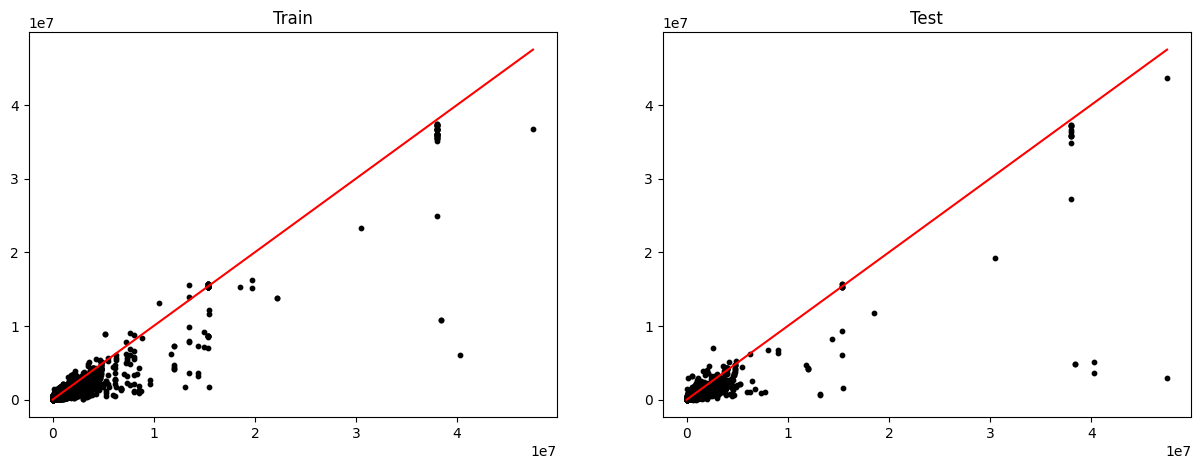

In [71]:
# Visualization

plot_results(y_train, train_pred, y_test, test_pred)

In [72]:
# Save

test = x_test.copy()
test[DATA_VALEUR_FONCIERE_COLUMN] = y_test
test = test.reset_index(drop=True)
test[DATA_CODE_POSTAL_COLUMN] = test[DATA_CODE_POSTAL_COLUMN].values.astype(int)
test[DATA_SURFACE_REELLE_COLUMN] = test[DATA_SURFACE_REELLE_COLUMN].values.astype(int)
test[DATA_SURFACE_TERRAIN_COLUMN] = test[DATA_SURFACE_TERRAIN_COLUMN].values.astype(int)
test[DATA_NB_PIECES_COLUMN] = test[DATA_NB_PIECES_COLUMN].values.astype(int)

joblib.dump(cat_trained_model, CAT_MODEl_PATH, compress=1)
joblib.dump(test, CAT_TEST_SET_PATH, compress=1)

['./models/cat_test']